# Single cosine distance classifier vs Ensemble of 4 classifiers 

### Load data and packages

The directory data  already exists
The directory output  already exists


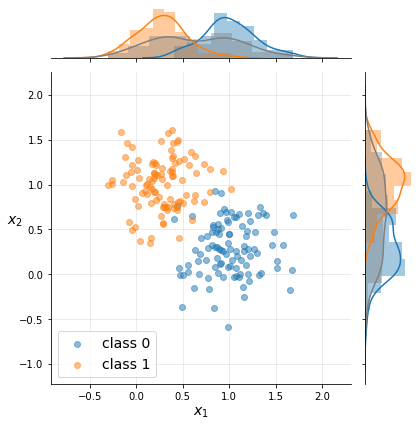

In [6]:
import sys

sys.path.insert(1, '../')

from Utils import *
from modeling import *

create_dir('data')
create_dir('output')

# seed = random.randint(1, 10000)
# np.random.seed(seed)
# print(seed)
seed = 962
np.random.seed(seed)

test_size = .1

X, y = load_data(n=200, std=.3, plot = True, save = False)

n_shots = 100
n_run = 5

### Split data in training and test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

Y_vector_train = label_to_array(y_train)
Y_vector_test = label_to_array(y_test)

print("Size Training Set: ", len(X_train))
print("Size Test Set: ", len(X_test))

Size Training Set:  180
Size Test Set:  20


### Quantum cosine classifier for all the observations of the test set

In [8]:
accuracy = []

for i in range(n_run):
    #initialisation
    n = range(len(X_train))
    TP = 0
    predictions = []
    probabilities = []

    for x_test, y_ts in zip(X_test, Y_vector_test):
        ix = np.random.choice(n, 1)[0]
        x_train = X_train[ix]
        x_tr = normalize_custom(x_train)
        y_tr = Y_vector_train[ix]
        x_ts = normalize_custom(x_test)

        qc = cos_classifier(x_tr, x_ts, y_tr)
        r = exec_simulator(qc, n_shots=n_shots)

        if '0' not in r.keys():
            r['0'] = 0
        elif '1' not in r.keys():
            r['1'] = 0

        p0 = (r['0'] / (r['0'] + r['1']))
        p0 = p0
        p1 = 1 - p0

        predictions.append(r)
        probabilities.append(predict_cos(r))
        probs = [p0, p1]


        if predict_cos(r)[0] > predict_cos(r)[1]:
            pred = [1, 0]
            pred = np.asarray(pred)
        else:
            pred = [0, 1]
            pred = np.asarray(pred)

        if np.array_equal(pred, y_ts):
            TP = TP + 1

    accuracy.append(TP / len(X_test))


cos_accuracy_mean = np.mean(accuracy)
cos_accuracy_std = np.std(accuracy)

print('AVG Accuracy multiple cosine classifier:', cos_accuracy_mean)
print('STD Accuracy multiple cosine classifier:', cos_accuracy_std)

print(qc)

AVG Accuracy multiple cosine classifier: 0.61
STD Accuracy multiple cosine classifier: 0.05830951894845297
              ┌─────────────────────────────┐ ░               ░         
   x^{(b)}_0: ┤ Initialize(0.81158,0.58423) ├─░───────X───────░─────────
              └┬───────────────────────────┬┘ ░       │       ░         
x^{(test)}_0: ─┤ Initialize(0.19402,0.981) ├──░───────X───────░─────────
               └────┬─────────────────┬────┘  ░       │       ░         
   y^{(b)}_0: ──────┤ Initialize(1,0) ├───────░───────┼───────░───■─────
                    └─────────────────┘       ░ ┌───┐ │ ┌───┐ ░ ┌─┴─┐┌─┐
y^{(test)}_0: ────────────────────────────────░─┤ H ├─■─┤ H ├─░─┤ X ├┤M├
                                              ░ └───┘   └───┘ ░ └───┘└╥┘
         c_0: ════════════════════════════════════════════════════════╩═
                                                                        


### Choose device

In [9]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
real_device = provider.get_backend('ibmq_16_melbourne')

all_acc_ens = []
all_brier_ens = []

ibmqfactory.load_account:WARNING:2020-05-15 14:33:19,562: Credentials are already in use. The existing account in the session will be replaced.


In [5]:
predictions = []
accuracy_ens = []
brier_ens = []

d=1

for i in range(n_run):
    n = range(len(X_train))
    predictions = []
    
    for x_test, y_ts in zip(X_test, Y_vector_test):

        X_data, Y_data = training_set(X_train, y_train, n=2**d)
        x_test = normalize_custom(x_test)

        qc = ensemble(X_data, Y_data, x_test, n_swap=1, d=d, balanced=True)
        qc = transpile(qc, basis_gates = ['u1', 'u2', 'u3', 'cx'], optimization_level=3)
        r = exec_simulator(qc, n_shots=n_shots)

        # job = execute(qc, real_device, shots = n_shots)
        # results = job.result()
        # r = results.get_counts(qc)

        predictions.append(retrieve_proba(r))
        
    acc, brier = evaluation_metrics(predictions, X_test, y_test)
    accuracy_ens.append(acc)
    brier_ens.append(brier)

IBMQJobFailureError: 'Unable to retrieve result for job 5ebe8afda7438f001911b94e. Job has failed. Use job.error_message() to get more details.'

In [6]:
ens_accuracy_mean = np.mean(accuracy_ens)
ens_accuracy_std = np.std(accuracy_ens)

print('AVG Accuracy ensemble:',ens_accuracy_mean, d)

ens_brier_mean = np.mean(brier_ens)
ens_brier_std = np.std(brier_ens)


all_acc_ens.append([ens_accuracy_mean, ens_accuracy_std])
all_brier_ens.append([ens_brier_mean, ens_brier_std])

AVG Accuracy ensemble: 0.93 1


In [7]:
predictions = []
accuracy_ens = []
brier_ens = []

d=2

for i in range(n_run):
    n = range(len(X_train))
    predictions = []
    
    for x_test, y_ts in zip(X_test, Y_vector_test):

        X_data, Y_data = training_set(X_train, y_train, n=2**d)
        x_test = normalize_custom(x_test)

        qc = ensemble(X_data, Y_data, x_test, n_swap=1, d=d, balanced=True)
        qc = transpile(qc, basis_gates = ['u1', 'u2', 'u3', 'cx'], optimization_level=3)
        # r = exec_simulator(qc, n_shots=n_shots)

        job = execute(qc, real_device, shots = n_shots)
        results = job.result()
        r = results.get_counts(qc)

        predictions.append(retrieve_proba(r))
        
    acc, brier = evaluation_metrics(predictions, X_test, y_test)
    accuracy_ens.append(acc)
    brier_ens.append(brier)

In [8]:
ens_accuracy_mean = np.mean(accuracy_ens)
ens_accuracy_std = np.std(accuracy_ens)

print('AVG Accuracy ensemble:',ens_accuracy_mean, d)

ens_brier_mean = np.mean(brier_ens)
ens_brier_std = np.std(brier_ens)


all_acc_ens.append([ens_accuracy_mean, ens_accuracy_std])
all_brier_ens.append([ens_brier_mean, ens_brier_std])

AVG Accuracy ensemble: 0.9 2


In [9]:
predictions = []
accuracy_ens = []
brier_ens = []

d=3

for i in range(n_run):
    n = range(len(X_train))
    predictions = []
    
    for x_test, y_ts in zip(X_test, Y_vector_test):

        X_data, Y_data = training_set(X_train, y_train, n=2**d)
        x_test = normalize_custom(x_test)

        qc = ensemble(X_data, Y_data, x_test, n_swap=1, d=d, balanced=True)
        qc = transpile(qc, basis_gates = ['u1', 'u2', 'u3', 'cx'], optimization_level=3)
        # r = exec_simulator(qc, n_shots=n_shots)

        job = execute(qc, real_device, shots = n_shots)
        results = job.result()
        r = results.get_counts(qc)

        predictions.append(retrieve_proba(r))
        
    acc, brier = evaluation_metrics(predictions, X_test, y_test)
    accuracy_ens.append(acc)
    brier_ens.append(brier)

IBMQJobFailureError: 'Unable to retrieve result for job 5eb9b49171f87a001b9d481d. Job has failed. Use job.error_message() to get more details.'

In [ ]:
ens_accuracy_mean = np.mean(accuracy_ens)
ens_accuracy_std = np.std(accuracy_ens)

ens_brier_mean = np.mean(brier_ens)
ens_brier_std = np.std(brier_ens)


all_acc_ens.append([ens_accuracy_mean, ens_accuracy_std])
all_brier_ens.append([ens_brier_mean, ens_brier_std])

In [ ]:
qc = ensemble(X_data, Y_data, x_test, n_swap=1, d=2, balanced=True)
qc.draw(output='text', scale = .1)

In [ ]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
real_device = provider.get_backend('ibmq_rome')

In [ ]:
accuracy = []

for i in range(10):
    #initialisation
    n = range(len(X_train))
    TP = 0
    predictions = []
    probabilities = []

    for x_test, y_ts in zip(X_test, Y_vector_test):
        ix = np.random.choice(n, 1)[0]
        x_train = X_train[ix]
        x_tr = normalize_custom(x_train)
        y_tr = Y_vector_train[ix]
        x_ts = normalize_custom(x_test)

        qc = cos_classifier(x_tr, x_ts, y_tr)
        # r = exec_simulator(qc, n_shots=n_shots)
        
        job = execute(qc, real_device, shots = n_shots)
        results = job.result()
        r = results.get_counts(qc)

        if '0' not in r.keys():
            r['0'] = 0
        elif '1' not in r.keys():
            r['1'] = 0

        p0 = (r['0'] / (r['0'] + r['1']))
        p0 = p0
        p1 = 1 - p0

        predictions.append(r)
        probabilities.append(predict_cos(r))
        probs = [p0, p1]


        if predict_cos(r)[0] > predict_cos(r)[1]:
            pred = [1, 0]
            pred = np.asarray(pred)
        else:
            pred = [0, 1]
            pred = np.asarray(pred)

        if np.array_equal(pred, y_ts):
            TP = TP + 1

    accuracy.append(TP / len(X_test))

print('AVG Accuracy multiple cosine classifier:', np.mean(accuracy))
print('STD Accuracy multiple cosine classifier:', np.std(accuracy))

print(qc)

In [ ]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
real_device = provider.get_backend('ibmq_16_melbourne')

In [ ]:
predictions = []

for x_test, y_ts in zip(X_test, Y_vector_test):

    X_data, Y_data = training_set(X_train, y_train, n=2)
    x_test = normalize_custom(x_test)

    qc = ensemble(X_data, Y_data, x_test, n_swap=1, d=1, balanced=True)
    
    job = execute(qc, real_device, shots = n_shots)
    results = job.result()
    r = results.get_counts(qc)

    predictions.append(retrieve_proba(r))
    print(retrieve_proba(r), y_ts)

In [ ]:
a, b = evaluation_metrics(predictions, X_test, y_test)
print(qc)